In [1]:
%load_ext autoreload
%autoreload 2

import train
import preprocessing
import test

import pandas as pd
from sodapy import Socrata
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
plt.rcParams['figure.figsize'] = [8,6]
plt.rcParams.update({'font.size': 12})
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# Pipeline:
1. Fetch data using sodapy query
2. Preprocessing
First some analysis is done to understand the trend, seasonality and residual behaviour of the time series.

In preprocessing, the datetime column is first converted to datetime type. Then features like year, month, day, hour, weekofyear, dayofweek are added. In the hints it as mentioned that weather data can be useful too. So, the weather data is colleted from wwo weather API for Seattle for the time period of the call data. The address, incident number, report location and type have not been used for modelling as it would be unknown what kind of call, or where zone the call would come for.

3. Analysis of daily calls
4. Modelling

5. Inferences

## Downloading the dataset
Setting up connection with the server to download the dataset
The SQL query was hardcoded

I tried querying such that the all records with dates only till 5 years from current time are fetch, but there is an inbuilt throttling from sodapy for 1000 records for a free public use token/account. So I hardcoded the number of records.

In [2]:
#Run to get new call data
client = Socrata("data.seattle.gov", None)

# Returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
results = client.get("kzjm-xkqj", limit = 1000000)


# Convert query results to pandas DataFrame
df = pd.DataFrame.from_records(results)
df = df.iloc[:,:7]
df = preprocessing.add_time_features(df)


# Run to get new weather data
from wwo_hist import retrieve_hist_data
frequency = 1
start_date = df.date.iloc[-1].strftime("%d-%b-%Y")
end_date = df.date.iloc[0].strftime("%d-%b-%Y")
api_key = '2d65942715e14539bbc163119222808'
location_list = ['seattle']
hist_weather_data = retrieve_hist_data(api_key,
                                location_list,
                                start_date,
                                end_date,
                                frequency,
                                location_label = False,
                                export_csv = False,
                                store_df = True)



Retrieving weather data for seattle


Currently retrieving data for seattle: from 2012-08-19 to 2012-08-31
Time elapsed (hh:mm:ss.ms) 0:00:00.351633
Currently retrieving data for seattle: from 2012-09-01 to 2012-09-30
Time elapsed (hh:mm:ss.ms) 0:00:00.967529
Currently retrieving data for seattle: from 2012-10-01 to 2012-10-31
Time elapsed (hh:mm:ss.ms) 0:00:01.589384
Currently retrieving data for seattle: from 2012-11-01 to 2012-11-30
Time elapsed (hh:mm:ss.ms) 0:00:02.195923
Currently retrieving data for seattle: from 2012-12-01 to 2012-12-31
Time elapsed (hh:mm:ss.ms) 0:00:02.857224
Currently retrieving data for seattle: from 2013-01-01 to 2013-01-31
Time elapsed (hh:mm:ss.ms) 0:00:03.501763
Currently retrieving data for seattle: from 2013-02-01 to 2013-02-28
Time elapsed (hh:mm:ss.ms) 0:00:04.108970
Currently retrieving data for seattle: from 2013-03-01 to 2013-03-31
Time elapsed (hh:mm:ss.ms) 0:00:04.995391
Currently retrieving data for seattle: from 2013-04-01 to 2013-04-30
Tim

Time elapsed (hh:mm:ss.ms) 0:00:51.296388
Currently retrieving data for seattle: from 2018-10-01 to 2018-10-31
Time elapsed (hh:mm:ss.ms) 0:00:51.937420
Currently retrieving data for seattle: from 2018-11-01 to 2018-11-30
Time elapsed (hh:mm:ss.ms) 0:00:52.557267
Currently retrieving data for seattle: from 2018-12-01 to 2018-12-31
Time elapsed (hh:mm:ss.ms) 0:00:53.209360
Currently retrieving data for seattle: from 2019-01-01 to 2019-01-31
Time elapsed (hh:mm:ss.ms) 0:00:53.858851
Currently retrieving data for seattle: from 2019-02-01 to 2019-02-28
Time elapsed (hh:mm:ss.ms) 0:00:54.443896
Currently retrieving data for seattle: from 2019-03-01 to 2019-03-31
Time elapsed (hh:mm:ss.ms) 0:00:55.090768
Currently retrieving data for seattle: from 2019-04-01 to 2019-04-30
Time elapsed (hh:mm:ss.ms) 0:00:55.744517
Currently retrieving data for seattle: from 2019-05-01 to 2019-05-31
Time elapsed (hh:mm:ss.ms) 0:00:56.408555
Currently retrieving data for seattle: from 2019-06-01 to 2019-06-30
T

In [3]:
weather = hist_weather_data[0]
weather = weather.rename({'date_time': 'datetime'}, axis=1)
weather = weather[['datetime','tempC','visibility','windspeedKmph','totalSnow_cm']]
weather[['tempC','visibility','windspeedKmph','totalSnow_cm']] = weather[['tempC','visibility','windspeedKmph','totalSnow_cm']].astype('float')
weather = preprocessing.add_time_features(weather)
weather['date'] = pd.to_datetime(weather[['year','month','day','hour']]).apply(lambda x: x.ctime())
weather = weather.set_index('date')
weather.head(5)

,datetime,tempC,visibility,windspeedKmph,totalSnow_cm,year,month,dayofweek,hour,day
date,,,,,,,,,,
Sun Aug 19 00:00:00 2012,2012-08-19 00:00:00,15.0,2.0,8.0,0.0,2012,8,6,0,19
Sun Aug 19 01:00:00 2012,2012-08-19 01:00:00,15.0,2.0,7.0,0.0,2012,8,6,1,19
Sun Aug 19 02:00:00 2012,2012-08-19 02:00:00,14.0,2.0,6.0,0.0,2012,8,6,2,19
Sun Aug 19 03:00:00 2012,2012-08-19 03:00:00,14.0,2.0,6.0,0.0,2012,8,6,3,19
Sun Aug 19 04:00:00 2012,2012-08-19 04:00:00,15.0,5.0,6.0,0.0,2012,8,6,4,19


## Initial daily call data analysis:


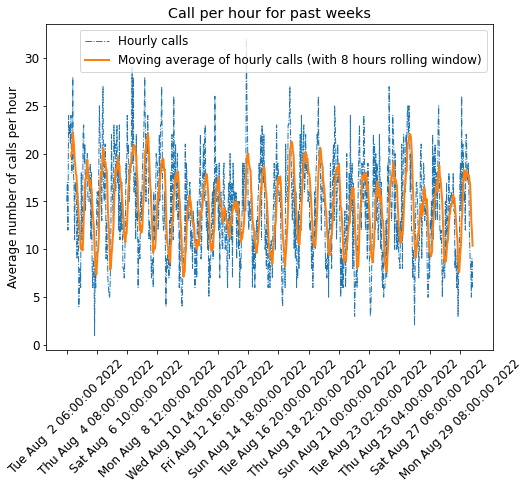

In [4]:
rolling_window = 8 #hours
grouped_df = preprocessing.group_df_func(df, ['year','month','day','hour'], date_col = True)
grouped_df = grouped_df.iloc[-4*7*24:].reset_index(drop=True)
fig, ax = plt.subplots()
ax.plot(grouped_df.num_calls, ls= '-.', label = 'Hourly calls', linewidth = 1)
ax.plot(grouped_df.num_calls.rolling(rolling_window).sum()/rolling_window, label = 'Moving average of hourly calls (with 8 hours rolling window)', linewidth = 2)
ax.set_ylabel('Average number of calls per hour')
ax.set_xticks(np.arange(len(grouped_df.date))[0::50])
_ = ax.set_xticklabels(grouped_df.date[0::50], rotation=45)
ax.set_title('Call per hour for past weeks')
plt.legend()
plt.show()

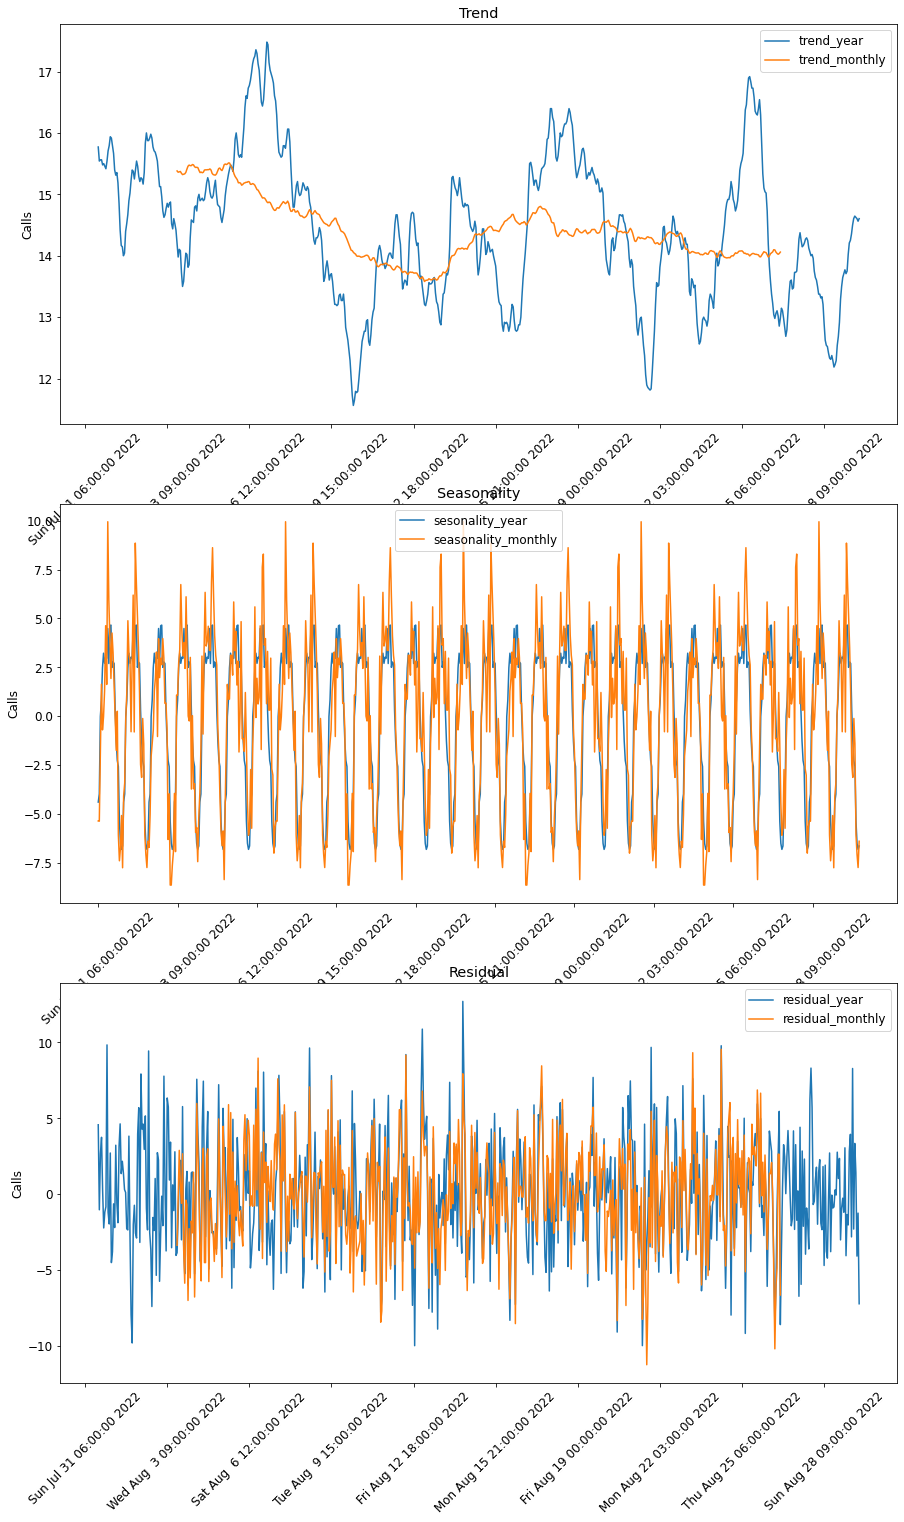

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose
grouped_df = preprocessing.group_df_func(df,  ['year', 'month', 'day','dayofweek','hour'], date_col = True)
grouped_df['num_calls_prev'] = grouped_df.num_calls.shift(1)
grouped_df['difference'] = grouped_df['num_calls'] - grouped_df['num_calls_prev']
grouped_df = grouped_df.iloc[-24*30:].reset_index(drop=True)

res_day = seasonal_decompose(grouped_df.num_calls, model = "additive",period = 24)
res_week = seasonal_decompose(grouped_df.num_calls, model = "additive",period = 24*7)

fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,25))

res_day.trend.plot(ax=ax1)
res_week.trend.plot(ax=ax1)
ax1.set_ylabel('Calls')
ax1.set_title('Trend')
ax1.legend(['trend_year', 'trend_monthly'])
ax1.set_xticks(np.arange(len(grouped_df.date))[0::75])
_ = ax1.set_xticklabels(grouped_df.date[0::75], rotation=45)

res_day.seasonal.plot(ax=ax2)
res_week.seasonal.plot(ax=ax2)
ax2.set_ylabel('Calls')
ax2.set_title('Seasonality')
ax2.legend(['sesonality_year', 'seasonality_monthly'])
ax2.set_xticks(np.arange(len(grouped_df.date))[0::75])
_ = ax2.set_xticklabels(grouped_df.date[0::75], rotation=45)

res_day.resid.plot(ax=ax3)
res_week.resid.plot(ax=ax3)
ax3.set_ylabel('Calls')
ax3.set_title('Residual')
ax3.legend(['residual_year', 'residual_monthly'])
ax3.set_xticks(np.arange(len(grouped_df.date))[0::75])
_ = ax3.set_xticklabels(grouped_df.date[0::75], rotation=45)
plt.show()

## Hourly calls prediction with weather data included

The mean squared error is: 15.786583263776839
The mean absolute error is: 3.160240886022427


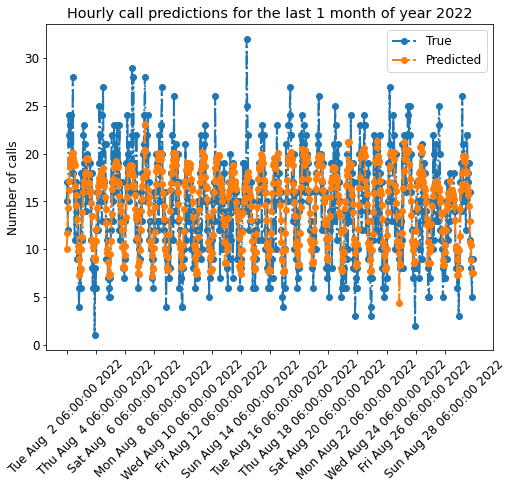

The mean squared error is: 14.569458216259827
The mean absolute error is: 3.0510563834293936


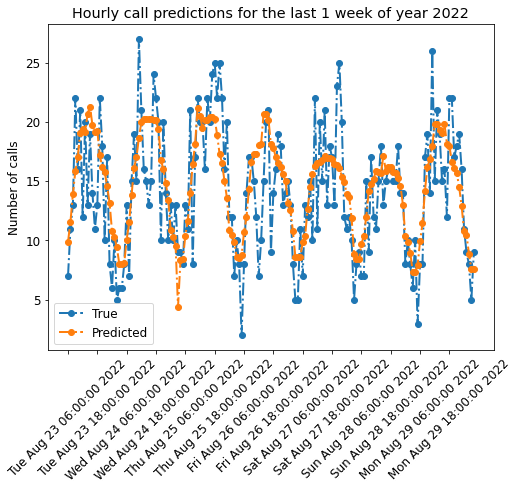

In [6]:
## grouping with respect to year, month, day, dayofweek and hour for the number of cases reported that day
grouped_df = preprocessing.group_df_func(df, ['year', 'month', 'day','dayofweek','hour'], date_col = True)
grouped_df = grouped_df.set_index('date')

grouped_df = pd.concat([grouped_df, weather[['tempC','windspeedKmph']]], axis = 1)
grouped_df = grouped_df.dropna(axis=0)
grouped_df = grouped_df.iloc[-24*30*18:]

## current month as test dataset and last 12 months as training dataset
test_df = grouped_df.iloc[-30*24:]
train_df = grouped_df.iloc[-30*12*24:-30*24]

model_hourly = train.train_model(GradientBoostingRegressor(), train_df, test_df, 'hourly', df.iloc[0].datetime.year)

results_df = test.test_model(model_hourly,test_df.iloc[-24*7*4:], 'hourly')
results_df = test.evaluate_predictions(results_df, 24*7*4, 'hourly', 'Hourly call predictions for the last 1 month of year 2022')

results_df = test.test_model(model_hourly,test_df.iloc[-24*7:], 'hourly')
results_df = test.evaluate_predictions(results_df, 24*7, 'hourly', 'Hourly call predictions for the last 1 week of year 2022')

## Hourly calls prediction with weather data and previous information included

The mean squared error is: 15.321398310617367
The mean absolute error is: 3.1145234254558227


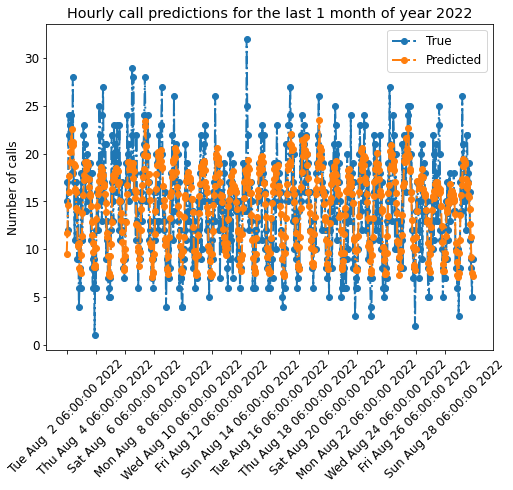

The mean squared error is: 13.751577623754722
The mean absolute error is: 2.969994286709103


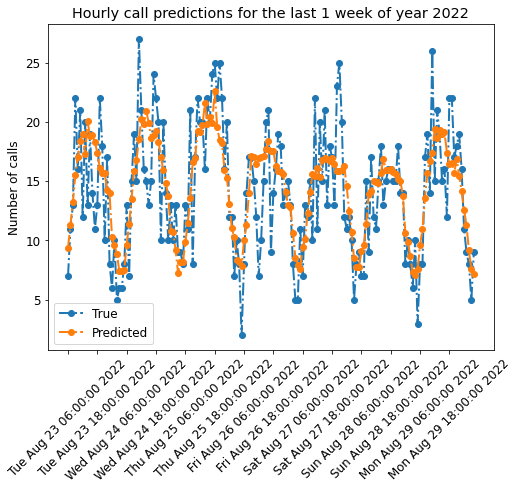

In [7]:
## grouping with respect to year, month, day, dayofweek and hour for the number of cases reported that day
grouped_df = preprocessing.group_df_func(df, ['year', 'month', 'day','dayofweek','hour'], date_col = True)

for i in range(8): #last 8 hour period included in the dataset
    grouped_df['num_calls_prev'+str(i+1)] = grouped_df.num_calls.shift(i+1)
grouped_df = grouped_df.set_index('date')

grouped_df = pd.concat([grouped_df, weather[['tempC','windspeedKmph']]], axis = 1)
grouped_df = grouped_df.dropna(axis=0)
grouped_df = grouped_df.iloc[-24*30*18:]

## current month as test dataset and last 12 months as training dataset
test_df = grouped_df.iloc[-30*24:]
train_df = grouped_df.iloc[-30*12*24:-30*24]

model_hourly = train.train_model(GradientBoostingRegressor(), train_df, test_df, 'hourly', df.iloc[0].datetime.year)

results_df = test.test_model(model_hourly,test_df.iloc[-24*7*4:], 'hourly')
results_df = test.evaluate_predictions(results_df, 24*7*4, 'hourly', 'Hourly call predictions for the last 1 month of year 2022')

results_df = test.test_model(model_hourly,test_df.iloc[-24*7:], 'hourly')
results_df = test.evaluate_predictions(results_df, 24*7, 'hourly', 'Hourly call predictions for the last 1 week of year 2022')

##### It can again be seen that the noise of the time series cannot be modelled completely. The model is able to learn the seasonality, but not the noise